In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from scipy.spatial import distance_matrix
import copy

# Question 1
## Part A
### Subpart 1
Below we first redefine the necessary functions from assignment 1.

In [2]:
def norm_img_hist(im):
    un, cts = np.unique(im.ravel(), return_counts=True)
    values = np.zeros(256)
    values[un] = cts / np.prod(np.shape(im))
    return values

def entropy(pmf):
    pmf = np.clip(pmf, 1e-15,1)
    return -np.sum(pmf*np.log2(pmf))

def divergence(p_pmf, q_pmf):
    p_pmf, q_pmf = np.clip(p_pmf, a_min=1e-15, a_max=1), np.clip(q_pmf, a_min=1e-15, a_max=1)
    return np.sum(p_pmf*np.log2(p_pmf/q_pmf))

In [3]:
left = image.imread('left.png')
left = np.int_(left*255)
right = image.imread('right.png')
right = np.int_(right*255)
a = norm_img_hist(left)
b = norm_img_hist(right)

Below we define the cross_entropy function to calculate the cross entropy between two pmfs.

In [4]:
def cross_entropy(p_, q_):
    return entropy(p_) + divergence(p_, q_)

Below we test our function cross_entropy on the pmfs of left and right stereo image pair.

In [5]:
c_entropy = cross_entropy(a, b)
print(c_entropy)

7.2733981199874265


### Subpart 2
r = 0.2


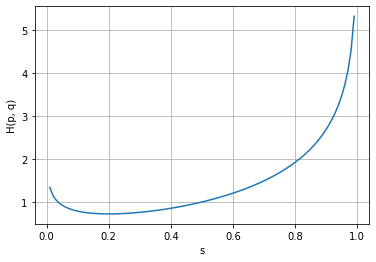

Minimum for H(p, q) occurs when s = 0.2


In [6]:
r = 0.2
q = np.linspace(0.01,0.99,99, endpoint=True)
fs = np.array([q,1-q])
p = np.array([r, 1-r])
c_entropy_p_q = np.zeros(99)
for i in range(99):
    c_entropy_p_q[i] = cross_entropy(p, fs[:,i])
plt.plot(q, c_entropy_p_q)
plt.xlabel("s")
plt.ylabel("H(p, q)")
plt.grid()
plt.show()
print("Minimum for H(p, q) occurs when s =",  q[np.argmin(c_entropy_p_q)])

Looking at above results, we can conclude that minimizing H(p, q) gives us matched PMFs.

## Part B
Below, we define the function js_divergence to find Jensen Shannon Divergence of two pmfs.

In [7]:
def js_divergence(p_, q_):
    return divergence(p_, (p_+q_)/2) + divergence(q_, (p_+q_)/2)

In [8]:
print("In below, assume that p refers to normalised histogram of left image and q refers to normalised histogram of right image.")

print("D(p||q) =", divergence(a, b))
print("D(q||p) =", divergence(b, a))
print("JS(p,q) =", js_divergence(a,b))
print("JS(q,p) =", js_divergence(b,a))

In below, assume that p refers to normalised histogram of left image and q refers to normalised histogram of right image.
D(p||q) = 0.015104015237387055
D(q||p) = 0.014409785833354484
JS(p,q) = 0.00734607953862966
JS(q,p) = 0.00734607953862966


We can observe that D(p||q)$\ne$D(q||p) but JS(p,q) = JS(q,p). This confirms the fact that JS(p,q) is symmetric while D(p||q) is not.

## Part C
Below we define check, that checks if a particular tuple (p, r, s) follows p$\in \Pi$(r, s).

In [9]:
def check(p_, r_, s_):
    return True if np.all(np.sum(p_, axis=0) == r_) and np.all(np.sum(p_, axis=1) == s_) else False

Now we verify our function using a positive and a negative example.

In [10]:
# Positive example: p = [[0.25 0.25]   , r = [0.5 0.5], s = [0.5 0.5]
#                        [0.25 0.25]]
p = np.array([[0.25, 0.25],[0.25, 0.25]])
r = np.array([0.5, 0.5])
s = np.array([0.5, 0.5])
print("Output for positive example: ", check(p, r, s))

# Positive example: p = [[0.25 0.25]   , r = [0.75 0.25], s = [0.5 0.5]
#                        [0.25 0.25]]
p = np.array([[0.25, 0.25],[0.25, 0.25]])
r = np.array([0.75, 0.25])
s = np.array([0.5, 0.5])
print("Output for Negative example: ", check(p, r, s))

Output for positive example:  True
Output for Negative example:  False


# Question 2
## Part A
### Subpart 1
In a lower dimensional space, it is impossible to reproduce the distances exactly as in a higher dimensional space because of the added dimensions. Suppose we want to represent four points that lie on a square in a 1 dimensional space. We will never be able to reproduce the same distance proportions as in the 2 dimensional space. This is called the crowding problem. This problem leads to crowding of data points in the lower dimensional space and prevents clusters from forming as we would otherwise have liked.
### Subpart 2
In the low dimensional embedding space, the choice of student-t distribution allows for moderately distanced points in higher dimensional space to be placed at larger distances in the lower dimensional space because of the heavier tails of the student-t distribution. This allows for nice clusters to form in the lower dimensional space. Thus the important correlations in the higher dimension is preserved after our dimensionality reduction procedure.
### Subpart 3
Another important change made in the t-SNE paper is that a symmetric pairwise similarity measure is used. In the higher dimension, the similarity between two points is given by $$p_{ij} = \dfrac{p_{i|j}+p_{j|i}}{2n}$$
In the lower dimension, after the use of student-t distribution, the symmetric similarity between two points is given by $$q_{ij}=\dfrac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\ne l}(1+||y_k-y_l||^2)^{-1}}$$

## Part B
Below we first generate the necessary data and then we implement and test t-SNE algorithm.

In [11]:
X1 = np.random.multivariate_normal(np.ones(10), 0.01*np.eye(10), 10)
X2 = np.random.multivariate_normal(10*np.ones(10), 0.01*np.eye(10), 10)
X = np.vstack((X1, X2))

Initial divergence:  1.0784992125617403


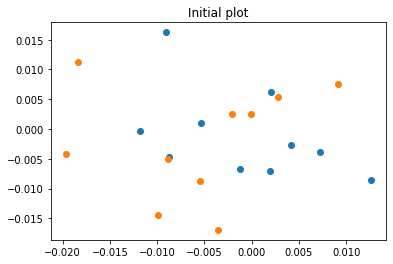

Final divergence:  1.0300177865399662


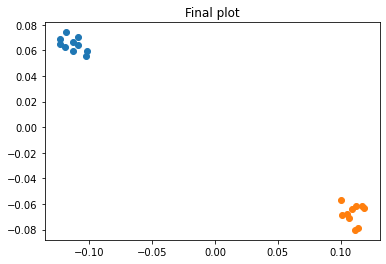

In [12]:
def tsne(data, eta, alpha, sigma, T, to_print=False):
    len_, dim = np.shape(data)
    y = np.random.multivariate_normal(np.zeros(2), 1e-4*np.eye(2), 20)
    y_prev = np.random.multivariate_normal(np.zeros(2), 1e-4*np.eye(2), 20)
    y_next = np.random.multivariate_normal(np.zeros(2), 1e-4*np.eye(2), 20)

    dists = distance_matrix(data, data)
    dists = np.exp(-dists**2/(2*sigma))
    dists[np.arange(len_), np.arange(len_)] = 0
    dists = dists/np.sum(dists,0)
    dists = (dists+dists.T)/(2*len_)

    y_dists = distance_matrix(y, y)
    y_dists = 1/(1+y_dists**2)
    y_dists[np.arange(len_), np.arange(len_)] = 0
    y_dists = y_dists/np.sum(y_dists)

    div = 0
    for j in range(len_):
        div += divergence(dists[j, :], y_dists[j, :])

    if to_print:
        print("Initial divergence: ", div)

        plt.scatter(y_next[:10,0], y_next[:10,1], marker='o')
        plt.scatter(y_next[10:,0], y_next[10:,1], marker='o')
        plt.title("Initial plot")
        plt.show()

    for j in range(T):
        y_prev = y
        y = y_next
        y_dists = distance_matrix(y, y)
        y_dists = 1/(1+y_dists**2)
        cp = copy.deepcopy(y_dists)
        y_dists = y_dists/np.sum(y_dists)
        grads = np.zeros_like(y)
        diff = dists-y_dists

        for m in range(len_):
            grads[m, :] = 4*np.sum((y[m,:]-y)*(diff[m,:]*cp[m,:])[:,np.newaxis],0)

        y_next = y - eta*grads - alpha*(y-y_prev)

    y_dists = distance_matrix(y_next, y_next)
    y_dists = 1/(1+y_dists**2)
    y_dists[np.arange(len_), np.arange(len_)] = 0
    y_dists = y_dists/np.sum(y_dists)

    div = 0
    for j in range(len_):
        div += divergence(dists[j, :], y_dists[j, :])

    if to_print:
        print("Final divergence: ", div)

        plt.scatter(y_next[:10,0], y_next[:10,1], marker='o')
        plt.scatter(y_next[10:,0], y_next[10:,1], marker='o')
        plt.title("Final plot")
        plt.show()

    return y_next

tsne(X, 1, 0.99, np.ones(20), 50, True)
print()

Below we experiment with the tsne function with different values of eta and alpha

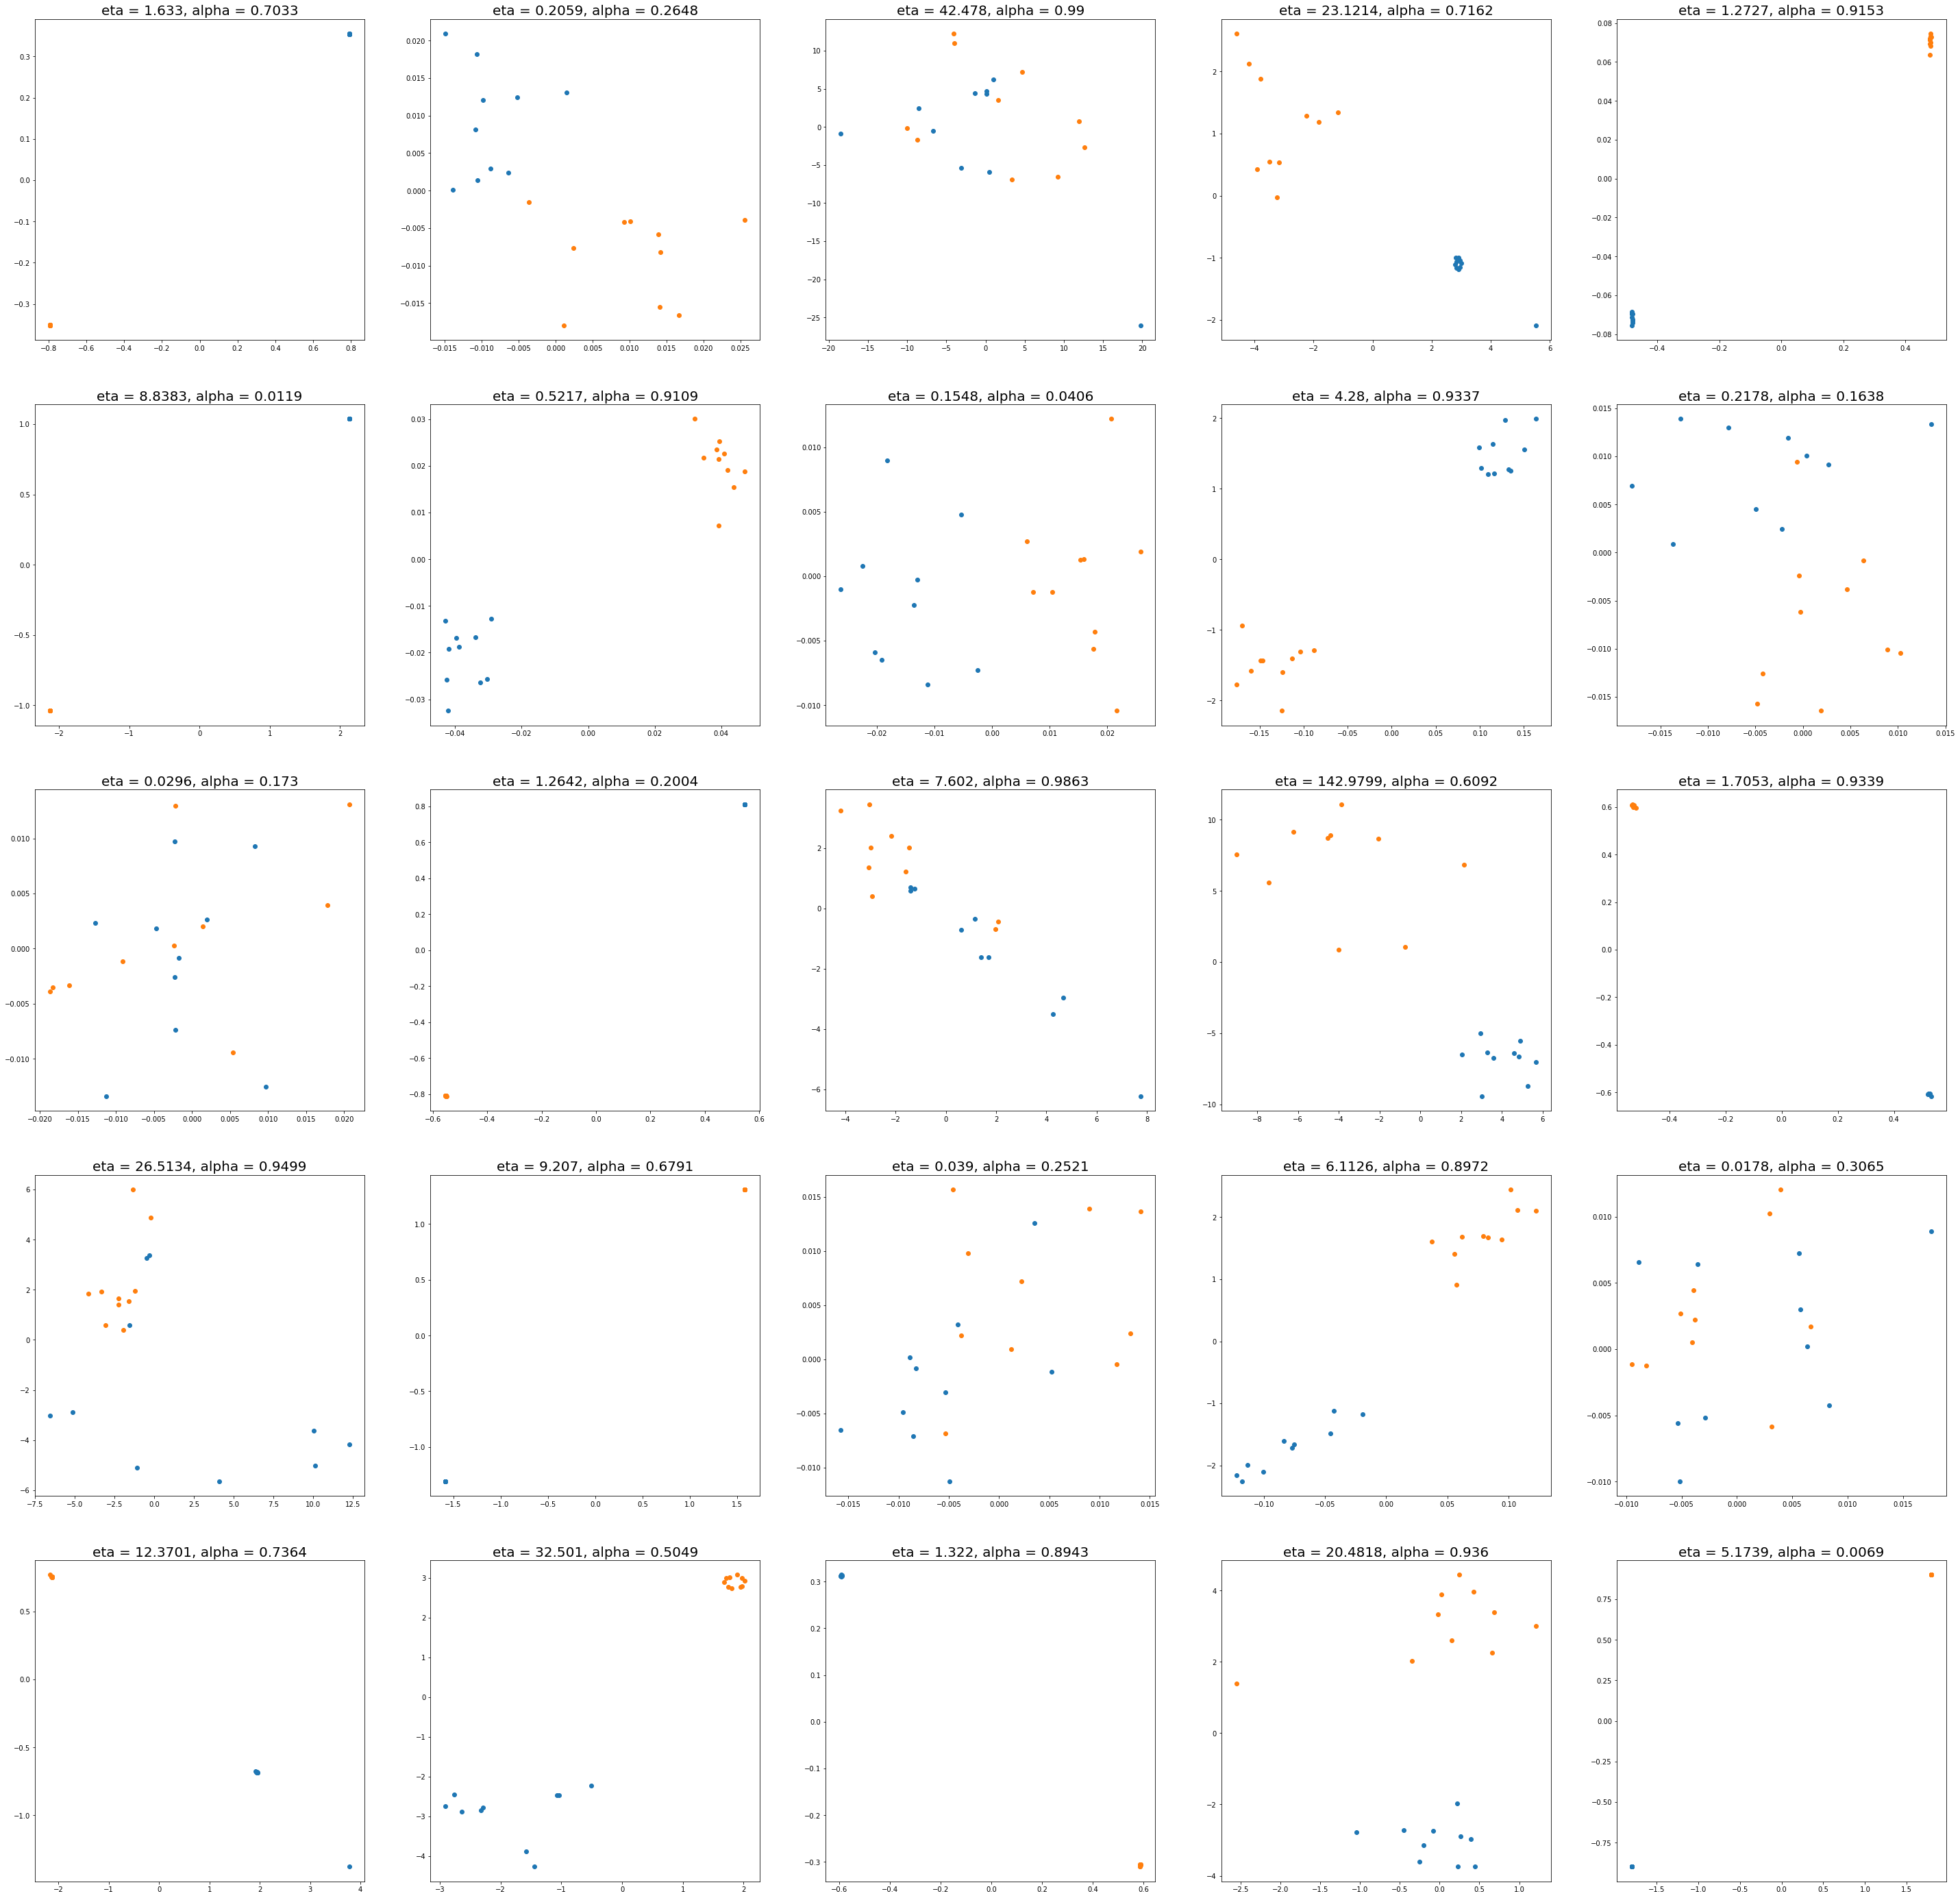

In [13]:
vals = np.random.uniform(-5, 5, [25, 2])
vals[:, 0] = np.exp(vals[:,0])
vals[:, 1] = 1/(1+np.exp(-vals[:, 1]))
fig = plt.figure(figsize=(50,50))
ax = fig.subplots(5,5)
o = 0
for i in range(25):
    if i % 5 == 0: o = 0
    x_embedded = tsne(X, vals[i, 0], vals[i, 1], np.ones(20), 50, False)
    ax[i//5][o].scatter(x_embedded[:10,0], x_embedded[:10,1], marker='o')
    ax[i//5][o].scatter(x_embedded[10:,0], x_embedded[10:,1], marker='o')
    ax[i//5][o].set_title("eta = "+str(np.round(vals[i, 0], 4))+", alpha = "+str(np.round(vals[i, 1], 4)), fontsize=20)
    o += 1

plt.show()

Below we test the TSNE utility from sklearn package with perplexity values 5, 20, 35 and 50.

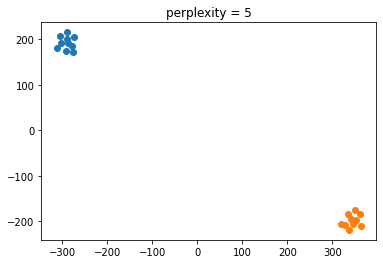

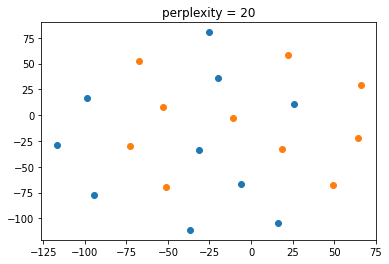

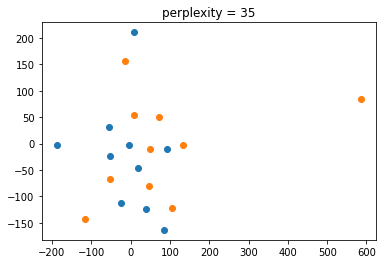

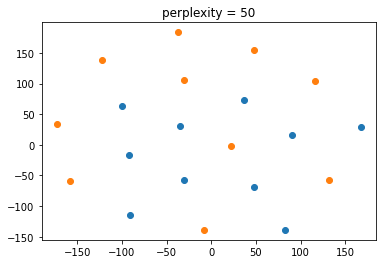

In [14]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2, init='random', perplexity=5).fit_transform(X)
plt.scatter(x_embedded[:10,0], x_embedded[:10,1], marker='o')
plt.scatter(x_embedded[10:,0], x_embedded[10:,1], marker='o')
plt.title("perplexity = 5")
plt.show()

x_embedded = TSNE(n_components=2, init='random', perplexity=20).fit_transform(X)
plt.scatter(x_embedded[:10,0], x_embedded[:10,1], marker='o')
plt.scatter(x_embedded[10:,0], x_embedded[10:,1], marker='o')
plt.title("perplexity = 20")
plt.show()

x_embedded = TSNE(n_components=2, init='random', perplexity=35).fit_transform(X)
plt.scatter(x_embedded[:10,0], x_embedded[:10,1], marker='o')
plt.scatter(x_embedded[10:,0], x_embedded[10:,1], marker='o')
plt.title("perplexity = 35")
plt.show()

x_embedded = TSNE(n_components=2, init='random', perplexity=50).fit_transform(X)
plt.scatter(x_embedded[:10,0], x_embedded[:10,1], marker='o')
plt.scatter(x_embedded[10:,0], x_embedded[10:,1], marker='o')
plt.title("perplexity = 50")
plt.show()

# Question 3
## Part A
Below we implement the convolution function as required.

In [15]:
def conv(img, kernel):
    K, _, _ = np.shape(kernel)
    H, W, C = np.shape(img)
    out_ = np.zeros([H, W])
    kernel = kernel[::-1, ::-1, :]

    horizontal_flip = img[:, ::-1, :]
    vertical_flip = img[::-1, :, :]
    full_flip = img[::-1, ::-1, :]
    padded_img = np.zeros([H+K-1, W+K-1, C])
    padded_img[K//2:H+K//2, K//2:W+K//2, :] = img #center
    padded_img[0:K//2, 0:K//2, :] = full_flip[-K//2+1:, -K//2+1:, :] #top left corner
    padded_img[0:K//2, K//2:W+K//2, :] = vertical_flip[-K//2+1:, :, :] #upper horizontal
    padded_img[K//2:H+K//2, 0:K//2, :] = horizontal_flip[:, -K//2+1:, :] # left vertical
    padded_img[-K//2+1:, 0:K//2, :] = full_flip[0:K//2, -K//2+1:, :] #lower left corner
    padded_img[0:K//2, -K//2+1:, :] = full_flip[-K//2+1:, 0:K//2, :] #upper right corner
    padded_img[-K//2+1:, K//2:W+K//2, :] = vertical_flip[0:K//2, :, :] #lower horizontal
    padded_img[K//2:H+K//2, -K//2+1:, :] = horizontal_flip[:, 0:K//2, :] #right vertical
    padded_img[-K//2+1:, -K//2+1:, :] = full_flip[0:K//2, 0:K//2, :] #lower right corner

    for m in range(H):
        for n in range(W):
            out_[m,n] = np.sum(padded_img[m:m+K, n:n+K, :]*kernel)

    out_ -= np.min(out_)
    out_ /= np.max(out_)
    out_ *= 255
    return out_

## Part B
Below we implement the correlation function as required.

In [16]:
def corr(img, kernel):
    K, _, _ = np.shape(kernel)
    H, W, C = np.shape(img)
    out_ = np.zeros([H, W])

    horizontal_flip = img[:, ::-1, :]
    vertical_flip = img[::-1, :, :]
    full_flip = img[::-1, ::-1, :]
    padded_img = np.zeros([H+K-1, W+K-1, C])
    padded_img[K//2:H+K//2, K//2:W+K//2, :] = img #center
    padded_img[0:K//2, 0:K//2, :] = full_flip[-K//2+1:, -K//2+1:, :] #top left corner
    padded_img[0:K//2, K//2:W+K//2, :] = vertical_flip[-K//2+1:, :, :] #upper horizontal
    padded_img[K//2:H+K//2, 0:K//2, :] = horizontal_flip[:, -K//2+1:, :] # left vertical
    padded_img[-K//2+1:, 0:K//2, :] = full_flip[0:K//2, -K//2+1:, :] #lower left corner
    padded_img[0:K//2, -K//2+1:, :] = full_flip[-K//2+1:, 0:K//2, :] #upper right corner
    padded_img[-K//2+1:, K//2:W+K//2, :] = vertical_flip[0:K//2, :, :] #lower horizontal
    padded_img[K//2:H+K//2, -K//2+1:, :] = horizontal_flip[:, 0:K//2, :] #right vertical
    padded_img[-K//2+1:, -K//2+1:, :] = full_flip[0:K//2, 0:K//2, :] #lower right corner

    for m in range(H):
        for n in range(W):
            out_[m,n] = np.sum(padded_img[m:m+K, n:n+K, :]*kernel)

    out_ -= np.min(out_)
    out_ /= np.max(out_)
    out_ *= 255
    return out_

Below we test our correlation and convolution functions with asymmetric kernels.

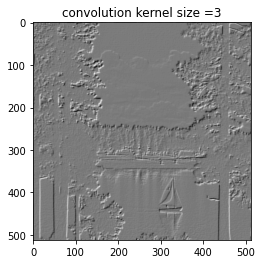

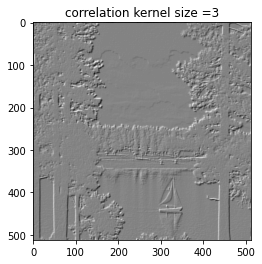

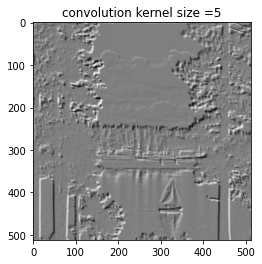

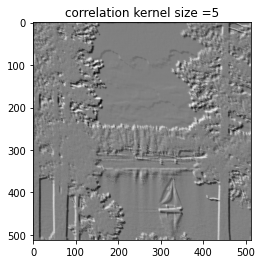

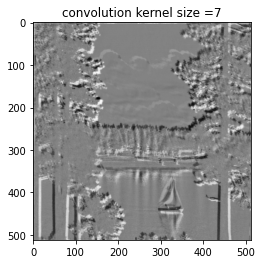

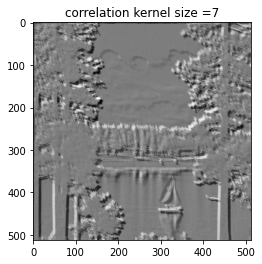

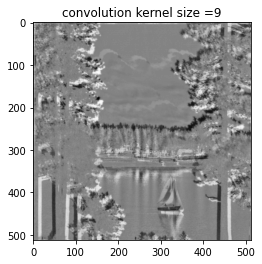

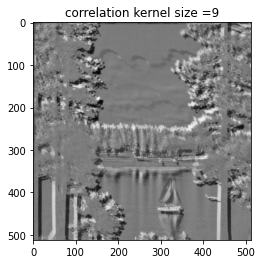

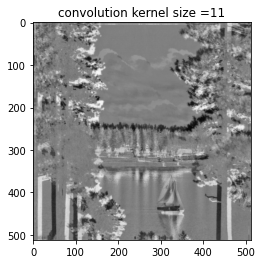

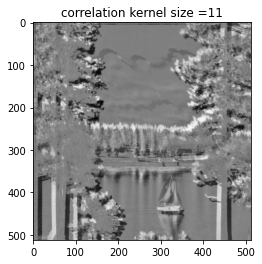

In [17]:
imag = image.imread("4.2.06.tiff")
for k_size in [3, 5, 7, 9, 11]:
    kern = np.zeros([k_size, k_size, 3])
    kern[0,0,:] = 1
    kern[-1,-1,:] = -1
    plt.imshow(conv(imag, kern), cmap='gray')
    plt.title("convolution kernel size ="+str(k_size))
    plt.show()
    plt.imshow(corr(imag, kern), cmap='gray')
    plt.title("correlation kernel size ="+str(k_size))
    plt.show()